In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [ ]:

print("--- PHASE 1: DATA LOADING (DEBUGGING) ---")

DATA_DIR = '../data/'
file_pattern = os.path.join(DATA_DIR, 'compoundV2_transactions_*.json')
all_files = sorted(glob.glob(file_pattern))

print(f"Searching for files with pattern: {file_pattern}")
if not all_files:
    raise FileNotFoundError(f"CRITICAL ERROR: No data files found. Please check your DATA_DIR path and that files exist.")

num_files_to_load = 20 
files_to_load = all_files[:num_files_to_load]
print(f"Found {len(all_files)} total files. Attempting to load the first {len(files_to_load)}...")


all_transactions = []
try:
    for i, path in enumerate(files_to_load):
        # DEBUG: Print which file is being processed
        print(f"  ({i+1}/{len(files_to_load)}) Processing {os.path.basename(path)}...")
        
        with open(path, 'r', encoding='utf-8') as f:
            data_chunk = json.load(f)
            
            # DEBUG: Check if the loaded chunk is a dictionary and has items
            if not isinstance(data_chunk, dict) or not data_chunk.items():
                print(f"    WARNING: File {os.path.basename(path)} is empty or not a valid dictionary. Skipping.")
                continue

            # This loop correctly handles keys with empty lists of transactions
            for tx_type, tx_list in data_chunk.items():
                # DEBUG: Announce what is being processed
                if isinstance(tx_list, list) and len(tx_list) > 0:
                    print(f"      -> Found {len(tx_list)} transactions of type '{tx_type}'. Adding to list.")
                    for tx in tx_list:
                        tx['transaction_type'] = tx_type 
                    all_transactions.extend(tx_list)
    
    # --- 1c. Create the DataFrame ---
    print("\nFinished processing all files.")
    print(f"Total transactions collected in the list: {len(all_transactions):,}")
    
    if all_transactions:
        df = pd.DataFrame(all_transactions)
        print(f"DataFrame created successfully! Shape: {df.shape}")
    else:
        print("CRITICAL WARNING: No transactions were collected. The DataFrame will be empty.")
        df = pd.DataFrame()

except Exception as e:
    print(f"\nFATAL: An error occurred during loading: {e}")
    # Create an empty DataFrame to prevent further errors
    df = pd.DataFrame()

--- PHASE 1: DATA LOADING (DEBUGGING) ---
Searching for files with pattern: ../data/compoundV2_transactions_*.json
Found 22 total files. Attempting to load the first 20...
  (1/20) Processing compoundV2_transactions_ethereum_chunk_0.json...
      -> Found 10000 transactions of type 'deposits'. Adding to list.
      -> Found 10000 transactions of type 'withdraws'. Adding to list.
      -> Found 10000 transactions of type 'borrows'. Adding to list.
      -> Found 10000 transactions of type 'repays'. Adding to list.
      -> Found 10000 transactions of type 'liquidates'. Adding to list.
  (2/20) Processing compoundV2_transactions_ethereum_chunk_1.json...
      -> Found 10000 transactions of type 'deposits'. Adding to list.
      -> Found 10000 transactions of type 'withdraws'. Adding to list.
      -> Found 10000 transactions of type 'borrows'. Adding to list.
      -> Found 10000 transactions of type 'repays'. Adding to list.
      -> Found 10000 transactions of type 'liquidates'. Adding

In [ ]:
print("\n--- PHASE 2: DATA CLEANING & NORMALIZATION (DEBUGGING) ---")
if not df.empty:
    
    # --- DEBUGGING: Inspect RAW columns before any changes ---
    print("\n--- RAW DATAFRAME COLUMNS ---")
    print("Columns available in the raw DataFrame:", df.columns.tolist())
    # Let's see the head of the raw data to check structure
    print("Head of raw data:")
    display(df.head())
    print("----------------------------\n")

    # --- Define intelligent extraction functions ---
    def get_wallet_id(row):
        if row.get('transaction_type') == 'liquidates':
            # Liquidations have 'borrower' and 'liquidator'
            if isinstance(row.get('borrower'), dict):
                return row.get('borrower').get('id')
            return None
        elif isinstance(row.get('account'), dict):
            # Other types have 'account'
            return row.get('account').get('id')
        return None

    # Apply the function to create the 'wallet' column
    df['wallet'] = df.apply(get_wallet_id, axis=1)
    
    # Rename other columns
    df.rename(columns={'amountUSD': 'amount_usd', 'timestamp': 'block_timestamp'}, inplace=True)
    
    # --- DEBUGGING BLOCK ---
    print("\n--- DEBUGGING AFTER CREATING 'wallet' COLUMN ---")
    print(f"Total rows before dropping NaNs: {len(df)}")
    # Count how many wallet IDs were successfully extracted vs. how many are null
    print(f"Number of nulls in 'wallet' column: {df['wallet'].isnull().sum()}")
    print("First 5 entries of the 'wallet' column:")
    print(df['wallet'].head())
    print("------------------------------------------------\n")

    # Select final columns and create a copy to avoid warnings
    final_cols = ['wallet', 'transaction_type', 'block_timestamp', 'amount_usd', 'hash']
    df = df[[col for col in final_cols if col in df.columns]].copy() 

    # Drop any rows where a wallet ID couldn't be extracted
    df.dropna(subset=['wallet'], inplace=True)
    
    print(f"\n--- AFTER DROPPING NaNs ---")
    print(f"Total rows remaining: {len(df)}")
    
    if not df.empty:
        print("Data cleaning successful. DataFrame is ready for feature engineering.")
        df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], unit='s')
        df['amount_usd'] = pd.to_numeric(df['amount_usd'], errors='coerce').fillna(0)
    else:
        print("\nCRITICAL ERROR: DataFrame became empty after dropping rows with null wallets.")
        print("This means the `get_wallet_id` function is not correctly extracting IDs from the raw JSON structure.")

else:
    print("ERROR: DataFrame was empty after Phase 1.")


--- PHASE 2: DATA CLEANING & NORMALIZATION (DEBUGGING) ---

--- RAW DATAFRAME COLUMNS ---
Columns available in the raw DataFrame: ['account', 'amount', 'amountUSD', 'asset', 'hash', 'id', 'timestamp', 'transaction_type', 'liquidatee', 'liquidator']
Head of raw data:


,account,amount,amountUSD,asset,hash,id,timestamp,transaction_type,liquidatee,liquidator
0,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,10000000000000000,1.78010000000000014408,{'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,0xa1b27194b198762eaa631564fea76008b363c157a1cc...,1557193282,deposits,NaN,NaN
1,{'id': '0xc8355d0e2c265b2fe495ebbc0fc9ad992b40...,80000000000000000,14.24080000000000115264,{'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,0x1d2000c49507d94ef42ec995e1ea59b41e61bf0c63d4...,1557193511,deposits,NaN,NaN
2,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,4582920657824222640301,1562.320140205329756474017145956277,{'id': '0x0d8775f648430679a709e98d2b0cb6250d28...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,0x4c3b59d70f6205a16f4d6f4c960d22ad332dd740720a...,1557195125,deposits,NaN,NaN
3,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,4013962940167102266494,4013.962940167102266494,{'id': '0x89d24a6b4ccb1b6faa2625fe562bdd9a2326...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,0xe8b31ff5cf7252a1a496dadfeccef667577d88cdf2c4...,1557195125,deposits,NaN,NaN
4,{'id': '0x502cb8985b2c92a8d4bf309cdaa89de9be44...,9990000000000000000,1775.4727500000001641357,{'id': '0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,0x0eda39d1cb1844e8c2f659219f5a414c0b8261e6dee5...,1557196912,deposits,NaN,NaN


----------------------------


--- DEBUGGING AFTER CREATING 'wallet' COLUMN ---
Total rows before dropping NaNs: 807840
Number of nulls in 'wallet' column: 20737
First 5 entries of the 'wallet' column:
0    0x502cb8985b2c92a8d4bf309cdaa89de9be442708
1    0xc8355d0e2c265b2fe495ebbc0fc9ad992b40dc8f
2    0x502cb8985b2c92a8d4bf309cdaa89de9be442708
3    0x502cb8985b2c92a8d4bf309cdaa89de9be442708
4    0x502cb8985b2c92a8d4bf309cdaa89de9be442708
Name: wallet, dtype: object
------------------------------------------------


--- AFTER DROPPING NaNs ---
Total rows remaining: 787103
Data cleaning successful. DataFrame is ready for feature engineering.


C:\Users\manju\AppData\Local\Temp\ipykernel_23032\2197880725.py:52: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], unit='s')


In [ ]:
print("\n--- PHASE 3: FEATURE ENGINEERING ---")
if 'df' in locals() and not df.empty:
    wallet_financials = df.pivot_table(index='wallet', columns='transaction_type', values='amount_usd', aggfunc='sum', fill_value=0)
    wallet_counts = df.pivot_table(index='wallet', columns='transaction_type', values='hash', aggfunc='nunique', fill_value=0)
    wallet_financials.columns = [f'{col}_usd' for col in wallet_financials.columns]
    wallet_counts.columns = [f'{col}_count' for col in wallet_counts.columns]
    all_possible_types = ['deposits', 'withdraws', 'borrows', 'repays', 'liquidates']
    for t_type in all_possible_types:
        if f'{t_type}_usd' not in wallet_financials: wallet_financials[f'{t_type}_usd'] = 0
        if f'{t_type}_count' not in wallet_counts: wallet_counts[f'{t_type}_count'] = 0
    wallet_features = pd.concat([wallet_financials, wallet_counts], axis=1)
    wallet_features['net_deposit_usd'] = wallet_features['deposits_usd'] - wallet_features['withdraws_usd']
    wallet_features['repay_borrow_ratio_usd'] = wallet_features['repays_usd'] / (wallet_features['borrows_usd'] + 1)
    wallet_history = df.groupby('wallet')['block_timestamp'].agg(['min', 'max'])
    wallet_features['wallet_age_days'] = (wallet_history['max'] - wallet_history['min']).dt.days
    wallet_features['is_liquidated'] = (wallet_features['liquidates_count'] > 0).astype(int)
    wallet_features.fillna(0, inplace=True)
    
    print("Feature engineering complete.")
    liquidated_count = wallet_features['is_liquidated'].sum()
    print(f"IMPORTANT: Found {liquidated_count} wallets that have been liquidated.")

print("\n--- PHASE 4: SAVING PROCESSED DATA ---")
if 'wallet_features' in locals() and not wallet_features.empty:
    output_dir = '../processed_data/'
    if not os.path.exists(output_dir): os.makedirs(output_dir)
    file_path = os.path.join(output_dir, 'wallet_features.pkl')
    wallet_features.to_pickle(file_path)
    print(f"Processed data saved to {file_path}")


--- PHASE 3: FEATURE ENGINEERING ---
Feature engineering complete.
IMPORTANT: Found 0 wallets that have been liquidated.

--- PHASE 4: SAVING PROCESSED DATA ---
Processed data saved to ../processed_data/wallet_features.pkl


In [2]:
import pandas as pd
import numpy as np
import json
import os
import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [3]:
DATA_DIR = '../data/'
files_to_load = sorted(glob.glob(os.path.join(DATA_DIR, 'compoundV2_transactions_*.json')))[:20]
if not files_to_load:
    raise FileNotFoundError(f"No data files found in '{DATA_DIR}'.")
print(f"Loading {len(files_to_load)} data files...")
all_transactions = []
for path in files_to_load:
    with open(path, 'r', encoding='utf-8') as f:
        data_chunk = json.load(f)
        for tx_type, tx_list in data_chunk.items():
            for tx in tx_list: tx['transaction_type'] = tx_type
            all_transactions.extend(tx_list)
df_raw = pd.DataFrame(all_transactions)
df = df_raw.copy()

Loading 20 data files...


In [4]:
def get_wallet_id(row):
    if row.get('transaction_type') == 'liquidates':
        if isinstance(row.get('liquidatee'), dict): return row.get('liquidatee').get('id')
    elif isinstance(row.get('account'), dict):
        return row.get('account').get('id')
    return None
df['wallet'] = df.apply(get_wallet_id, axis=1)
df.rename(columns={'amountUSD': 'amount_usd', 'timestamp': 'block_timestamp'}, inplace=True)
final_cols = ['wallet', 'transaction_type', 'block_timestamp', 'amount_usd', 'hash']
df = df[[col for col in final_cols if col in df.columns]].copy()
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], unit='s')
df['amount_usd'] = pd.to_numeric(df['amount_usd'], errors='coerce').fillna(0)
df.dropna(subset=['wallet'], inplace=True)
print("Data loading and cleaning complete.")

C:\Users\manju\AppData\Local\Temp\ipykernel_2664\1481444190.py:11: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['block_timestamp'] = pd.to_datetime(df['block_timestamp'], unit='s')


Data loading and cleaning complete.


C:\Users\manju\AppData\Local\Temp\ipykernel_2664\479192317.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='transaction_type', data=df, order=df['transaction_type'].value_counts().index, palette='viridis')


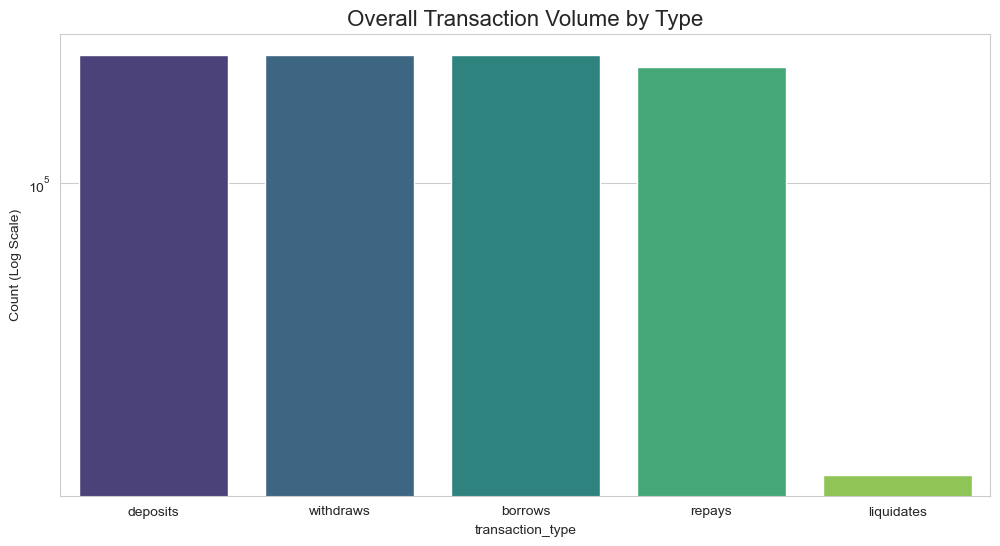

In [5]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='transaction_type', data=df, order=df['transaction_type'].value_counts().index, palette='viridis')
ax.set_title('Overall Transaction Volume by Type', fontsize=16)
ax.set_yscale('log')
ax.set_ylabel("Count (Log Scale)")
plt.show()

C:\Users\manju\AppData\Local\Temp\ipykernel_2664\1484580178.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


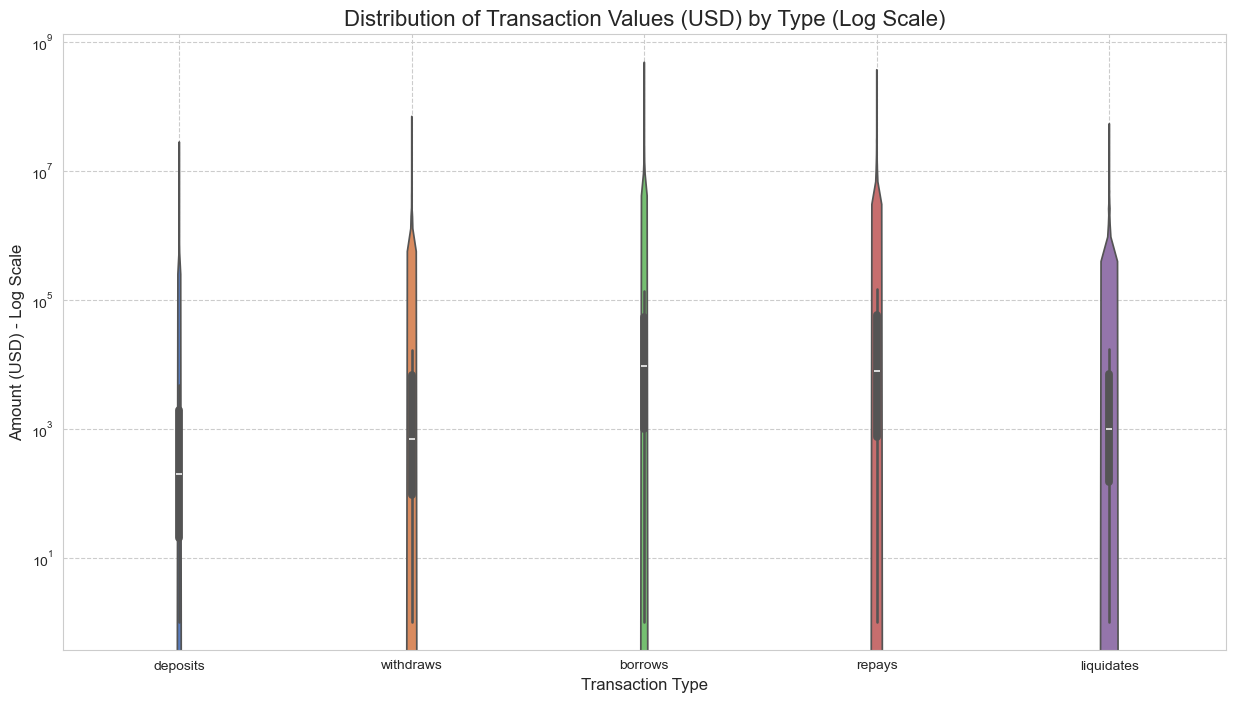

Insight: Deposits and Borrows have a wide range of values, while Repays are often smaller, indicating partial repayments.


In [6]:
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=df[df['amount_usd'] > 1],
    x='transaction_type', 
    y='amount_usd',
    palette='muted'
)
plt.yscale('log')
plt.title('Distribution of Transaction Values (USD) by Type (Log Scale)', fontsize=16)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Amount (USD) - Log Scale', fontsize=12)
plt.grid(True, which="both", ls="--")
plt.show()
print("Insight: Deposits and Borrows have a wide range of values, while Repays are often smaller, indicating partial repayments.")

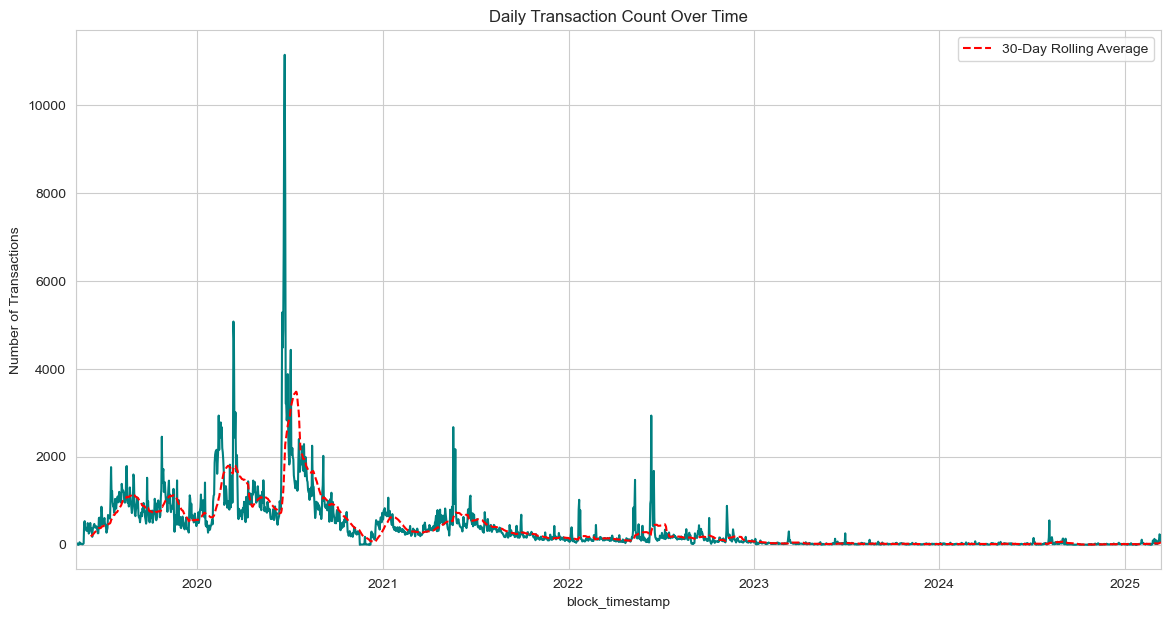

Insight: We can observe periods of high activity (e.g., 'DeFi Summer') and market downturns.


In [7]:

daily_activity = df.set_index('block_timestamp').resample('D').size()
plt.figure()
daily_activity.plot(title='Daily Transaction Count Over Time', color='teal')
plt.ylabel('Number of Transactions')
plt.xlabel('Date')
daily_activity.rolling(window=30).mean().plot(label='30-Day Rolling Average', color='red', linestyle='--')
plt.legend()
plt.show()
print("Insight: We can observe periods of high activity (e.g., 'DeFi Summer') and market downturns.")

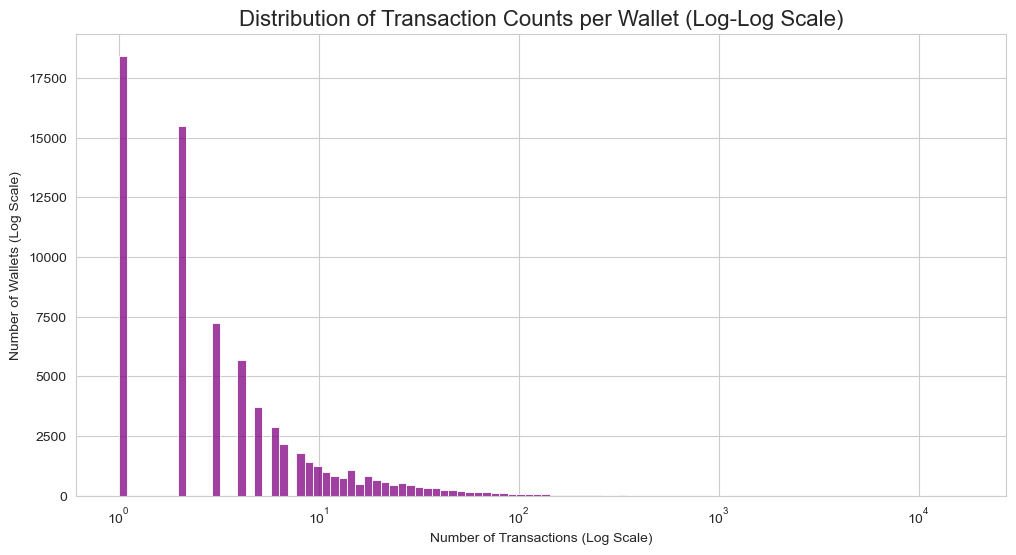

Insight: A classic 'power law' distribution. Most wallets have very few transactions, while a few 'power users' or bots have thousands.
This justifies creating features like 'total_tx_count' to capture this behavior.


In [8]:

wallet_tx_counts = df.groupby('wallet')['hash'].nunique()
plt.figure(figsize=(12, 6))
sns.histplot(wallet_tx_counts, bins=100, log_scale=True, color='purple')
plt.xscale('log')
plt.title('Distribution of Transaction Counts per Wallet (Log-Log Scale)', fontsize=16)
plt.xlabel('Number of Transactions (Log Scale)')
plt.ylabel('Number of Wallets (Log Scale)')
plt.show()
print("Insight: A classic 'power law' distribution. Most wallets have very few transactions, while a few 'power users' or bots have thousands.")
print("This justifies creating features like 'total_tx_count' to capture this behavior.")

In [9]:
wallet_financials = df.pivot_table(index='wallet', columns='transaction_type', values='amount_usd', aggfunc='sum', fill_value=0)
wallet_counts = df.pivot_table(index='wallet', columns='transaction_type', values='hash', aggfunc='nunique', fill_value=0)
wallet_financials.columns = [f'{col}_usd' for col in wallet_financials.columns]
wallet_counts.columns = [f'{col}_count' for col in wallet_counts.columns]
all_possible_types = ['deposits', 'withdraws', 'borrows', 'repays', 'liquidates']
for t_type in all_possible_types:
    if f'{t_type}_usd' not in wallet_financials: wallet_financials[f'{t_type}_usd'] = 0
    if f'{t_type}_count' not in wallet_counts: wallet_counts[f'{t_type}_count'] = 0
wallet_features = pd.concat([wallet_financials, wallet_counts], axis=1)

wallet_features['net_deposit_usd'] = wallet_features['deposits_usd'] - wallet_features['withdraws_usd']
wallet_features['repay_borrow_ratio_usd'] = wallet_features['repays_usd'] / (wallet_features['borrows_usd'] + 1)
wallet_features['total_tx_count'] = wallet_features[[col for col in wallet_features.columns if '_count' in col]].sum(axis=1)
wallet_features['is_liquidated'] = (wallet_features['liquidates_count'] > 0).astype(int)
wallet_history = df.groupby('wallet')['block_timestamp'].agg(['min', 'max'])
wallet_features['wallet_age_days'] = (wallet_history['max'] - wallet_history['min']).dt.days
wallet_features.fillna(0, inplace=True)
print("Feature engineering complete.")


Feature engineering complete.


In [10]:
output_dir = '../processed_data/'
if not os.path.exists(output_dir): os.makedirs(output_dir)
file_path = os.path.join(output_dir, 'wallet_features.pkl')
wallet_features.to_pickle(file_path)
print(f"Processed data saved to {file_path}")

Processed data saved to ../processed_data/wallet_features.pkl
